# Несбалансированные выборки. Практическая работа

## Цель практической работы

Научиться обрабатывать несбалансированные данные и обучать модели машинного обучения на таких данных.

## Что входит в работу


1. Загрузить данные и провести разведочный анализ.
2. Разделить данные на обучающую и тестовую выборки.
3. Подготовить данные для моделирования.
4. Сбалансировать данные методом SMOTE и обучить модель машинного обучения.
5. Обучить модель машинного обучения с использованием весов классов и кросс-валидации.
6. Сравнить метрики качества четырёх моделей.




## Что оценивается 

- Выполнены все этапы работы.
- Не допущена утечка данных при разделении выборок и подготовке данных.
- Данные корректным образом сбалансированы.
- Модели не переобучены.


## Как отправить работу на проверку

Скачайте файл с заданиями в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.


# Задача

Пусть у нас имеется некоторый набор данных `german_credit_data.csv` о заёмщиках банка:

* Age — возраст заёмщика.
* Sex — пол заёмщика.
* Job — тип работы заёмщика.
* Housing — тип жилья заёмщика.
* Saving accounts — объём средств на сберегательных счетах заёмщика.
* Checking account — объём средств на основном счёте заёмщика.
* Credit amount — размер кредита. 
* Duration — срок кредита (в месяцах).
* Purpose — цель кредита.
* Risk — таргет, допустил ли заёмщик просрочку платежей по кредиту.

Решите задачу классификации заёмщиков, чтобы банк умел заранее предсказывать просрочку платежей по кредиту. 



# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('german_credit_data.csv')
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


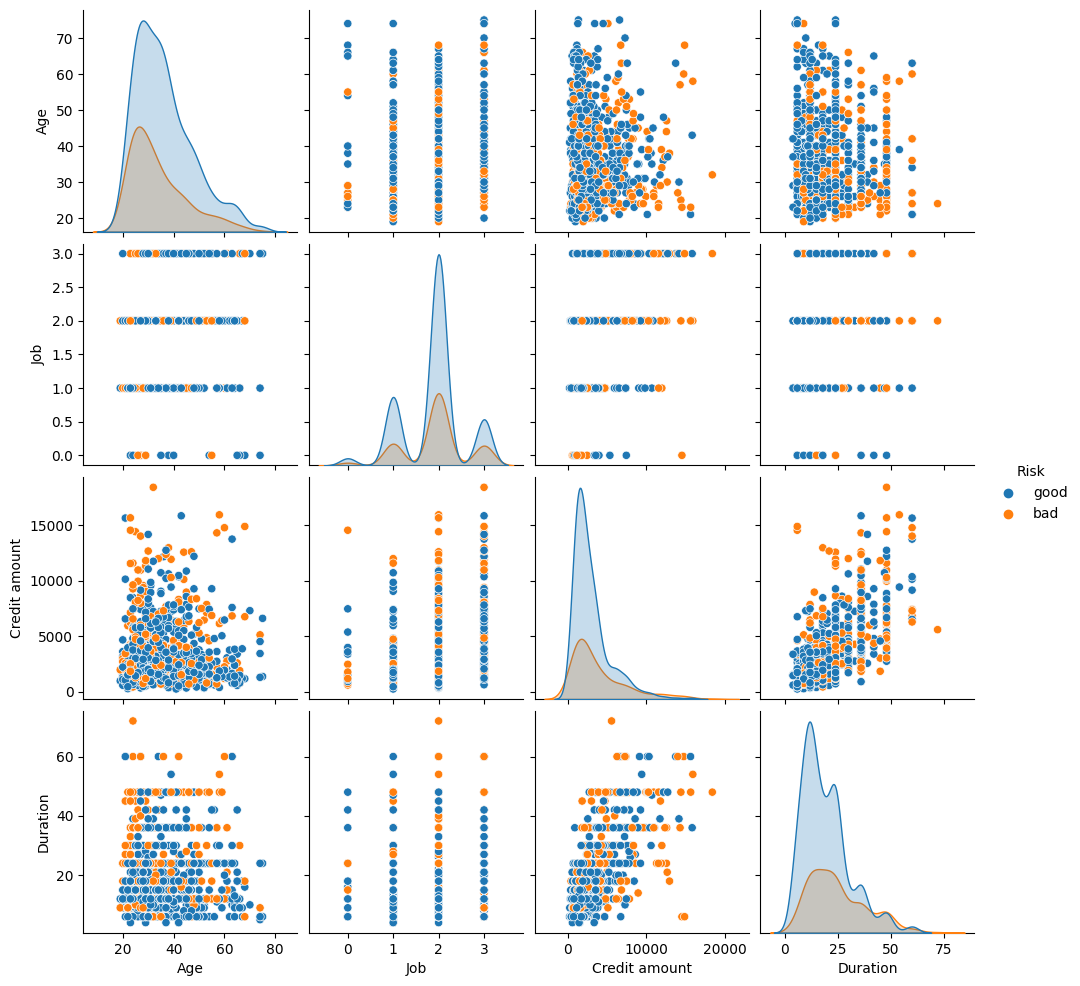

In [5]:
sns.pairplot(df, hue='Risk')

In [6]:
df.Sex.value_counts()

Sex
male      690
female    310
Name: count, dtype: int64

In [7]:
df.Housing.value_counts()

Housing
own     713
rent    179
free    108
Name: count, dtype: int64

In [8]:
df['Saving accounts'].value_counts()

Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64

In [9]:
df['Checking account'].value_counts()

Checking account
little      274
moderate    269
rich         63
Name: count, dtype: int64

In [10]:
df['Purpose'].value_counts()

Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: count, dtype: int64

In [11]:
df['Risk'].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

**Ответы**

По числовым параметрам явных вылетов нет, хоть и данные имеют вылетающие за пределы межквартильного расстояния значения. Но размер датасета небольшой поэтому оставлю эти значения.

По категориальным признакам количество категорий не много. Но по признакам "Saving accounts" и "Checking account" есть не заполненные поля. Размер датасета небольшой поэтому буду заполнять наиболее частым значением.

Целевой признак "Risk" заполнен полностью, имеет дисбаланс классов.

# Задание 2

Разделите датасет на обучающую и тестовую выборки в пропорции 80:20. Разделение должно быть стратифицированным по таргету Risk.

В этом и следующих заданиях используйте random_state = 1.

In [12]:
RS = 1
target = 'Risk'

df[target] = df[target].apply(lambda x: 1 if x == 'bad' else 0)
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,0
996,40,male,3,own,little,little,3857,30,car,0
997,38,male,2,own,little,NaN,804,12,radio/TV,0
998,23,male,2,free,little,little,1845,45,radio/TV,1


In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df[target], random_state=RS)

In [14]:
df_train.reset_index(drop= True , inplace= True )

In [15]:
df_test.reset_index(drop= True , inplace= True )

# Задание 3

Проведите этап очистки и подготовки данных (data preparation) и подготовьте данные к моделированию.

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer

In [17]:
# заполним пустые поля часто встречающимися значениями
imp_cat = SimpleImputer(strategy='most_frequent')

In [18]:
cols_to_impute = ['Saving accounts', 'Checking account']
df_train[cols_to_impute] = imp_cat.fit_transform(df_train[cols_to_impute])
df_test[cols_to_impute] = imp_cat.transform(df_test[cols_to_impute])

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               800 non-null    int64 
 1   Sex               800 non-null    object
 2   Job               800 non-null    int64 
 3   Housing           800 non-null    object
 4   Saving accounts   800 non-null    object
 5   Checking account  800 non-null    object
 6   Credit amount     800 non-null    int64 
 7   Duration          800 non-null    int64 
 8   Purpose           800 non-null    object
 9   Risk              800 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 62.6+ KB


In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               200 non-null    int64 
 1   Sex               200 non-null    object
 2   Job               200 non-null    int64 
 3   Housing           200 non-null    object
 4   Saving accounts   200 non-null    object
 5   Checking account  200 non-null    object
 6   Credit amount     200 non-null    int64 
 7   Duration          200 non-null    int64 
 8   Purpose           200 non-null    object
 9   Risk              200 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 15.8+ KB


In [21]:
# перекодируем категориальные переменные в числовые
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
data = ohe.fit_transform(df_train[cat_cols])
df_train[ohe.get_feature_names_out()] = data

In [22]:
data = ohe.transform(df_test[cat_cols])
df_test[ohe.get_feature_names_out()] = data

In [23]:
# отнормируем числовые данные
num_cols = ['Age', 'Job', 'Credit amount', 'Duration']
mmx_scaler = MinMaxScaler()
data = mmx_scaler.fit_transform(df_train[num_cols])
df_train[num_cols] = data

In [24]:
data = mmx_scaler.transform(df_test[num_cols])
df_test[num_cols] = data

In [25]:
# удалим нечисловые колонки
df_train = df_train.drop(columns=cat_cols)
df_test = df_test.drop(columns=cat_cols)

In [26]:
# Данные для обучения и тестирования
X_train, y_train = df_train.drop(columns=target), df_train[target]
X_test, y_test = df_test.drop(columns=target), df_test[target]

In [27]:
y_train.value_counts()

Risk
0    560
1    240
Name: count, dtype: int64

# Задание 4

Сбалансируйте обучающую выборку методом SMOTE и обучите модель RandomForestClassifier. Подберите оптимальные гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [28]:
ovs = SMOTE(random_state=RS)
X_ovs, y_ovs = ovs.fit_resample(X_train, y_train)
y_ovs.value_counts()

Risk
0    560
1    560
Name: count, dtype: int64

In [921]:
rf_1 = RandomForestClassifier(n_estimators=9, 
                              criterion='log_loss',  # criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
                              max_depth=19, 
                              random_state=RS, 
#                               ccp_alpha=0.000002, 
                              max_leaf_nodes=2,
                              min_weight_fraction_leaf=0.15, 
                              min_samples_split= 2, 
#                               min_samples_leaf=3,
                              max_samples=0.10,  # 'max_samples': [None, 10, 30, 40, 50, 100] 0.3179  0.561
                              class_weight={0:1.5, 1:1},
                              max_features='log2',#4,  # 'max_features': ['sqrt', 'log2', None]
#                               min_impurity_decrease=0.0018,#0.001,
                             )
rf_1.fit(X_ovs, y_ovs)
pred_1 = rf_1.predict_proba(X_test)[:, 1:]
score_1 = roc_auc_score(y_test, pred_1)
score_1

0.7557142857142857

In [30]:
from sklearn.model_selection import GridSearchCV

In [38]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=25)
path = tree.cost_complexity_pruning_path(X=X_ovs, y=y_ovs)
alphas = path['ccp_alphas']

In [39]:
alphas

array([0.        , 0.00057398, 0.00058401, 0.00059524, 0.00059524,
       0.00066964, 0.00066964, 0.00071429, 0.00071429, 0.00071429,
       0.00074405, 0.00074405, 0.00074405, 0.00078125, 0.00078125,
       0.00079063, 0.00079438, 0.0007967 , 0.00080357, 0.00080357,
       0.00080357, 0.00083705, 0.00084034, 0.00084586, 0.00085183,
       0.00085404, 0.00086207, 0.00089286, 0.00089286, 0.00089286,
       0.00092593, 0.00095238, 0.00103175, 0.00104374, 0.00106293,
       0.00107143, 0.00107143, 0.00110544, 0.00111607, 0.00112245,
       0.00113796, 0.00115041, 0.00118153, 0.00119048, 0.00119048,
       0.00119048, 0.00119048, 0.00119048, 0.0012381 , 0.00125   ,
       0.00125   , 0.00126984, 0.00129738, 0.00131494, 0.00132124,
       0.00133929, 0.00133929, 0.00133929, 0.00133929, 0.00133929,
       0.00133929, 0.00136054, 0.00142857, 0.00142857, 0.00142857,
       0.00145089, 0.00145833, 0.00146104, 0.0014881 , 0.0014881 ,
       0.0014881 , 0.0014881 , 0.0014881 , 0.00151193, 0.00153

In [160]:
%%time
params = {#'n_estimators': [140],
          'n_estimators': range(2, 22, 1),          
#           'max_depth': range(3, 30, 1),
          'max_depth': [25],
#           'min_samples_split': range(2, 25),
#           'min_samples_leaf': range(1, 10, 1),
#           'min_weight_fraction_leaf': [0, 0.05, 0.1, 0.15, 0.2],
#           'max_leaf_nodes': [10, 50, 100, None],
#           'min_impurity_decrease': [0, 0.0001, 0.001, 0.01, 0.1],
#           'bootstrap': [True, False],
#           'bootstrap': [False],  
#           'ccp_alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 40],
          'ccp_alpha': alphas,
#           'max_samples': [None, 10, 30, 40, 50, 100]
#           'max_features': ['sqrt', 'log2', None]
         }
# rf_2 = RandomForestClassifier(random_state=RS, n_jobs=-1)
rf_2 = RandomForestClassifier(random_state=RS, n_jobs=-1, max_features=4)
# rf_2 = RandomForestClassifier(random_state=RS, n_jobs=-1, max_leaf_nodes=2, min_weight_fraction_leaf=0.19, min_samples_split=2,
#                              class_weight={0:1.6, 1:1})
gs = GridSearchCV(rf_2, params, cv=3, scoring='roc_auc', verbose=1)
gs.fit(X_ovs, y_ovs)
rf_2 = gs.best_estimator_
gs.best_score_

Fitting 3 folds for each of 2600 candidates, totalling 7800 fits
CPU times: total: 4min 13s
Wall time: 4min 21s


0.8050188538727235

In [161]:
rf_2

RandomForestClassifier(ccp_alpha=0.0006696428571428571, max_depth=25,
                       max_features=4, n_estimators=21, n_jobs=-1,
                       random_state=1)

In [162]:
rf_2.fit(X_ovs, y_ovs)
pred_2 = rf_2.predict_proba(X_test)[:, 1:]
score_2 = roc_auc_score(y_test, pred_2)
score_2, gs.best_params_

(0.6820238095238096,
 {'ccp_alpha': 0.0006696428571428571, 'max_depth': 25, 'n_estimators': 21})

0.6926190476190476
0.645297619047619
0.6450595238095238
0.655595238095238
0.637202380952381
(0.6704761904761904, {'bootstrap': False, 'ccp_alpha': 0, 'max_depth': 16, 'n_estimators': 140})
(0.6492261904761905, {'bootstrap': False, 'ccp_alpha': 0, 'n_estimators': 140})
(0.6704761904761904, {'bootstrap': False, 'max_depth': 16, 'n_estimators': 140})
(0.6616666666666666, {'bootstrap': False,  'max_depth': 160,  'min_samples_split': 4,  'n_estimators': 80})
(0.6798809523809524, {'max_depth': 160, 'min_samples_leaf': 1, 'n_estimators': 180})
(0.6859523809523811, {'max_depth': 16, 'min_weight_fraction_leaf': 0, 'n_estimators': 200})
(0.6757738095238096, {'max_depth': 19, 'max_leaf_nodes': None, 'n_estimators': 200})
(0.6788095238095239, {'max_depth': 25, 'min_impurity_decrease': 0, 'n_estimators': 200})
(0.6573809523809525, {'bootstrap': False, 'max_depth': 19, 'n_estimators': 160})
(0.6760119047619048, {'ccp_alpha': 0.0001, 'max_depth': 19, 'n_estimators': 200})
(0.6788095238095239, {'ccp_alpha': 0.0, 'max_depth': 25, 'n_estimators': 200})
(0.6788095238095239, {'max_depth': 25, 'max_samples': None, 'n_estimators': 200})
(0.6947619047619048, {'max_depth': 3, 'n_estimators': 220})
(0.6947619047619048, {'max_depth': 3, 'n_estimators': 230})
(0.7076190476190476, {'max_depth': 5, 'n_estimators': 110})
(0.7085714285714285, {'max_depth': 5, 'n_estimators': 56})
(0.7316666666666666, {'ccp_alpha': 0.0005739795918367346, 'max_depth': 25, 'n_estimators': 21})
(0.6820238095238096, {'ccp_alpha': 0.0006696428571428571, 'max_depth': 25, 'n_estimators': 21})
  

# Задание 5

Обучите модель RandomForestClassifier с использованием весов классов. Подберите оптимальные веса и гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [78]:
rf_3 = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=RS, class_weight='balanced')
rf_3.fit(X_train, y_train)
pred_3 = rf_3.predict_proba(X_test)[:, 1:]
score_3 = roc_auc_score(y_test, pred_3)
score_3

0.6992261904761904

In [693]:
rf_3 = RandomForestClassifier(n_estimators=19, 
                              criterion='gini',  # criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
                              max_depth=19, 
                              min_samples_split=2, 
#                               min_samples_leaf=1,
                              min_weight_fraction_leaf=0.19,     
                              max_leaf_nodes=2,
                              max_features='log2',#4,  # 'max_features': ['sqrt', 'log2', None]
                              max_samples=0.8192,  # 'max_samples': [None, 10, 30, 40, 50, 100]
                              random_state=RS, 
                              ccp_alpha=0.002,
                              min_impurity_decrease=0.001,
                              class_weight= {0:1, 1:1.389},  #  'balanced_subsample',                             
                              bootstrap=True,
#                               oob_score=True
                             )
rf_3.fit(X_train, y_train)
pred_3 = rf_3.predict_proba(X_test)[:, 1:]
score_3 = roc_auc_score(y_test, pred_3)
score_3


0.7413690476190476

In [723]:
rf_3 = RandomForestClassifier(n_estimators=25, 
                              criterion='log_loss',  # criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
                              max_depth=14,#None, #19, 
                              min_samples_split= 3, 
                              min_samples_leaf=3,
                              min_weight_fraction_leaf=0.0049, #0.19,     
                              max_leaf_nodes=None,#2,
                              max_features=None,  # 'max_features': ['sqrt', 'log2', None]
                              max_samples=0.9985,  # 'max_samples': [None, 10, 30, 40, 50, 100]
                              random_state=RS, 
                              ccp_alpha=0.000105,
                              min_impurity_decrease=0.000305,#0.001,
                              class_weight= {0:1, 1:48},  #  'balanced_subsample',                             
                              bootstrap=True,
                              oob_score=False
                             )
rf_3.fit(X_train, y_train)
pred_3 = rf_3.predict_proba(X_test)[:, 1:]
score_3 = roc_auc_score(y_test, pred_3)
score_3


0.7505952380952381

In [95]:
%%time
params = {'n_estimators': range(80, 201, 20),
          'max_depth': range(5, 20),
#           'max_features': ['sqrt', 'log2', None]
         }
rf_4 = RandomForestClassifier(random_state=RS, class_weight='balanced')
gs = GridSearchCV(rf_4, params, cv=4, scoring='roc_auc', verbose=1)
gs.fit(X_train, y_train)
rf_4 = gs.best_estimator_
gs.best_score_

Fitting 4 folds for each of 105 candidates, totalling 420 fits
CPU times: total: 1min 43s
Wall time: 1min 43s


0.6628869047619047

In [96]:
rf_4

RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=160,
                       random_state=1)

In [97]:
rf_4.fit(X_ovs, y_ovs)
pred_4 = rf_4.predict_proba(X_test)[:, 1:]
score_4 = roc_auc_score(y_test, pred_4)
score_4

0.6973809523809524